In [11]:
import numpy as np
from util.plot import plot_cdf,color_list,plot_cdf_sub
from util.func import decode_dict,map_percentiles
from util.const import MTU,UNIT_G,LINK_TO_DELAY_DICT,SIZE_BUCKET_LIST_OUTPUT,get_base_delay_transmission,get_base_delay
import matplotlib.pyplot as plt


In [2]:
def is_sorted(arr):
    if all(arr[i] <= arr[i+1] for i in range(len(arr)-1)):
        return True
    # elif all(arr[i] >= arr[i+1] for i in range(len(arr)-1)):
    #     return False
    else:
        return False
    

In [3]:
dir_input="/data2/lichenni/path_tc"
dir_input_str=''
topo_type_ori="_topo-pl-x_"
lr=10
BDP=10*MTU
SIZE_BUCKET_LIST=[MTU, BDP, 5 * BDP]
enable_longest_foreground_traffic=True
lr_bottleneck=lr

In [4]:

shard_list=np.arange(2000)
nhosts_list=[3,5,7]
# shard_seed_list=np.arange(20)
shard_seed_list=[1]

res_error=np.zeros((len(shard_list),len(nhosts_list),len(shard_seed_list),len(SIZE_BUCKET_LIST_OUTPUT)+2,2,4))

for shard_idx,shard in enumerate(shard_list):
    print(f"shard={shard}")
    for n_flows in [20000]:
        for n_hosts_idx,n_hosts in enumerate(nhosts_list):
            for shard_seed_idx,shard_seed in enumerate(shard_seed_list):
                topo_type=topo_type_ori.replace("-x_",f"-{n_hosts}_")+"s%d"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps{dir_input_str}"
                src_dst_pair_target=(0,n_hosts-1)
                
                # print(f"spec={spec},{topo_type}")
                dir_input_tmp = f"{dir_input}/{spec}"
                
                # param_vec = np.load(f"{dir_input_tmp}/param{topo_type}.npy")
                # print(f"param_vec={param_vec}")
                
                fid=np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
                # fid=np.sort(fid)
                
                sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
                fats_flowsim = np.load(f"{dir_input_tmp}/fat.npy")
                flow_src_dst_flowsim=np.load(f'{dir_input_tmp}/fsd.npy')
                
                assert len(fid)==len(sizes_flowsim)
                
                # flowsim
                flow_idx_target_flowsim=np.logical_and(flow_src_dst_flowsim[:,0]==src_dst_pair_target[0], flow_src_dst_flowsim[:,1]==src_dst_pair_target[1])

                flow_idx_nontarget_flowsim=~flow_idx_target_flowsim
                flow_idx_nontarget_internal_flowsim=np.logical_and(flow_src_dst_flowsim[:,0]!=src_dst_pair_target[0], flow_src_dst_flowsim[:,1]!=src_dst_pair_target[1])

                n_links_passed=abs(flow_src_dst_flowsim[:,0]-flow_src_dst_flowsim[:,1])+flow_idx_nontarget_flowsim+flow_idx_nontarget_internal_flowsim
                
                base_delay=get_base_delay(sizes_flowsim,n_links_passed,lr_bottleneck,flow_idx_target_flowsim,flow_idx_nontarget_internal_flowsim)+LINK_TO_DELAY_DICT[n_hosts][flow_src_dst_flowsim[:,0]]+LINK_TO_DELAY_DICT[n_hosts][flow_src_dst_flowsim[:,1]]
                i_fcts_flowsim = get_base_delay_transmission(sizes_flowsim,lr_bottleneck) + base_delay
                fcts_flowsim = np.load(f'{dir_input}/{spec}/fct_flowsim.npy')+ base_delay
                sldns_flowsim = np.divide(fcts_flowsim, i_fcts_flowsim)

                sizes_flowsim_target=sizes_flowsim[flow_idx_target_flowsim]
                sldns_flowsim_target=sldns_flowsim[flow_idx_target_flowsim]
                # fcts_flowsim_target=fcts_flowsim[flow_idx_target_flowsim]
                # i_fcts_flowsim_target=i_fcts_flowsim[flow_idx_target_flowsim]
                bins_flowsim_target = np.digitize(sizes_flowsim_target, SIZE_BUCKET_LIST)
                
                # ns-3
                # sizes=sizes_flowsim[fid]
                # fats=fats_flowsim[fid]
                # flow_src_dst=flow_src_dst_flowsim[fid]
                sizes=sizes_flowsim
                fats=fats_flowsim
                flow_src_dst=flow_src_dst_flowsim
                
                flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
                
                fcts = np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
                i_fcts = np.load(f'{dir_input_tmp}/fct_i{topo_type}.npy')
                sldns = np.divide(fcts, i_fcts)
                assert len(sldns)==len(sldns_flowsim)
                # sldns = i_fcts
                
                # flow_idx_target=~flow_idx_target
                sizes_target=sizes[flow_idx_target]
                sldns_target=sldns[flow_idx_target]
                # fcts_target=fcts[flow_idx_target]
                # i_fcts_target=i_fcts[flow_idx_target]
                
                bins_target = np.digitize(sizes_target, SIZE_BUCKET_LIST)
                
                # print(f"sizes={len(sizes)}, fats={len(fats)}, fcts={len(fcts)}, i_fcts={len(i_fcts)}, sldns={len(sldns)}")
                # deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
                # print(f"{deq_time_max}s")
                
                sldn_ns3_list=[]
                sldn_flowsim_list_v1=[]
                sldn_flowsim_list_v2=[]
                
                for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
                    gt = np.extract(bins_target==i, sldns_target)
                    gt_flowsim = np.extract(bins_flowsim_target==i, sldns_flowsim_target)
                    
                    if(len(gt)==0): continue
                    
                    gt_flowsim_map=map_percentiles(gt_flowsim,gt)
                    for tmp_idx,tmp in enumerate([gt_flowsim,gt_flowsim_map]):
                        res_error[shard_idx,n_hosts_idx,shard_seed_idx,i,tmp_idx,0]=np.mean(np.abs(gt - tmp))
                        res_error[shard_idx,n_hosts_idx,shard_seed_idx,i,tmp_idx,1]=np.sqrt(np.mean((gt - tmp) ** 2))
                        res_error[shard_idx,n_hosts_idx,shard_seed_idx,i,tmp_idx,2]=np.mean(np.abs(gt - tmp)/gt)
                        res_error[shard_idx,n_hosts_idx,shard_seed_idx,i,tmp_idx,3]=np.percentile(np.abs(gt - tmp)/gt,95)
                    sldn_ns3_list.extend(gt)
                    sldn_flowsim_list_v1.extend(gt_flowsim)
                    sldn_flowsim_list_v2.extend(gt_flowsim_map)
                
                target_idx=len(SIZE_BUCKET_LIST_OUTPUT)
                for tmp_idx,tmp in enumerate([sldns_flowsim_target,map_percentiles(sldns_flowsim_target,sldns_target)]):
                    res_error[shard_idx,n_hosts_idx,shard_seed_idx,target_idx,tmp_idx,0]=np.mean(np.abs(sldns_target - tmp))
                    res_error[shard_idx,n_hosts_idx,shard_seed_idx,target_idx,tmp_idx,1]=np.sqrt(np.mean((sldns_target - tmp) ** 2))
                    res_error[shard_idx,n_hosts_idx,shard_seed_idx,target_idx,tmp_idx,2]=np.mean(np.abs(sldns_target - tmp)/sldns_target)
                    res_error[shard_idx,n_hosts_idx,shard_seed_idx,target_idx,tmp_idx,3]=np.percentile(np.abs(sldns_target - tmp)/sldns_target,95)
                
                sldn_ns3_list=np.array(sldn_ns3_list)
                sldn_flowsim_list_v1=np.array(sldn_flowsim_list_v1)
                sldn_flowsim_list_v2=np.array(sldn_flowsim_list_v2)
                target_idx=len(SIZE_BUCKET_LIST_OUTPUT)+1
                for tmp_idx,tmp in enumerate([sldn_flowsim_list_v1,sldn_flowsim_list_v2]):
                    res_error[shard_idx,n_hosts_idx,shard_seed_idx,target_idx,tmp_idx,0]=np.mean(np.abs(sldn_ns3_list - tmp))
                    res_error[shard_idx,n_hosts_idx,shard_seed_idx,target_idx,tmp_idx,1]=np.sqrt(np.mean((sldn_ns3_list - tmp) ** 2))
                    res_error[shard_idx,n_hosts_idx,shard_seed_idx,target_idx,tmp_idx,2]=np.mean(np.abs(sldn_ns3_list - tmp)/sldn_ns3_list)
                    res_error[shard_idx,n_hosts_idx,shard_seed_idx,target_idx,tmp_idx,3]=np.percentile(np.abs(sldn_ns3_list - tmp)/sldn_ns3_list,95)
                        
                print(f"shard={shard},n_hosts={n_hosts},shard_seed={shard_seed},error={res_error[shard_idx,n_hosts_idx,shard_seed_idx,-1,:,2]}")

shard=0
shard=0,n_hosts=3,shard_seed=1,error=[0.06557898 0.08846827]
shard=0,n_hosts=5,shard_seed=1,error=[0.00488167 0.00506269]
shard=0,n_hosts=7,shard_seed=1,error=[0.00961308 0.01177762]
shard=1
shard=1,n_hosts=3,shard_seed=1,error=[0.00226654 0.00211202]
shard=1,n_hosts=5,shard_seed=1,error=[0.04593193 0.04505808]
shard=1,n_hosts=7,shard_seed=1,error=[0.08676242 0.06051914]
shard=2
shard=2,n_hosts=3,shard_seed=1,error=[0.06677413 0.07413453]
shard=2,n_hosts=5,shard_seed=1,error=[0.06800967 0.05162272]
shard=2,n_hosts=7,shard_seed=1,error=[0.47435687 0.06918609]
shard=3
shard=3,n_hosts=3,shard_seed=1,error=[0.14707382 0.1026621 ]
shard=3,n_hosts=5,shard_seed=1,error=[0.14413429 0.02327823]
shard=3,n_hosts=7,shard_seed=1,error=[0.18357109 0.04360068]
shard=4
shard=4,n_hosts=3,shard_seed=1,error=[0.22599003 0.2820836 ]
shard=4,n_hosts=5,shard_seed=1,error=[0.0088071  0.00306404]
shard=4,n_hosts=7,shard_seed=1,error=[0.07642045 0.07189041]
shard=5
shard=5,n_hosts=3,shard_seed=1,error=

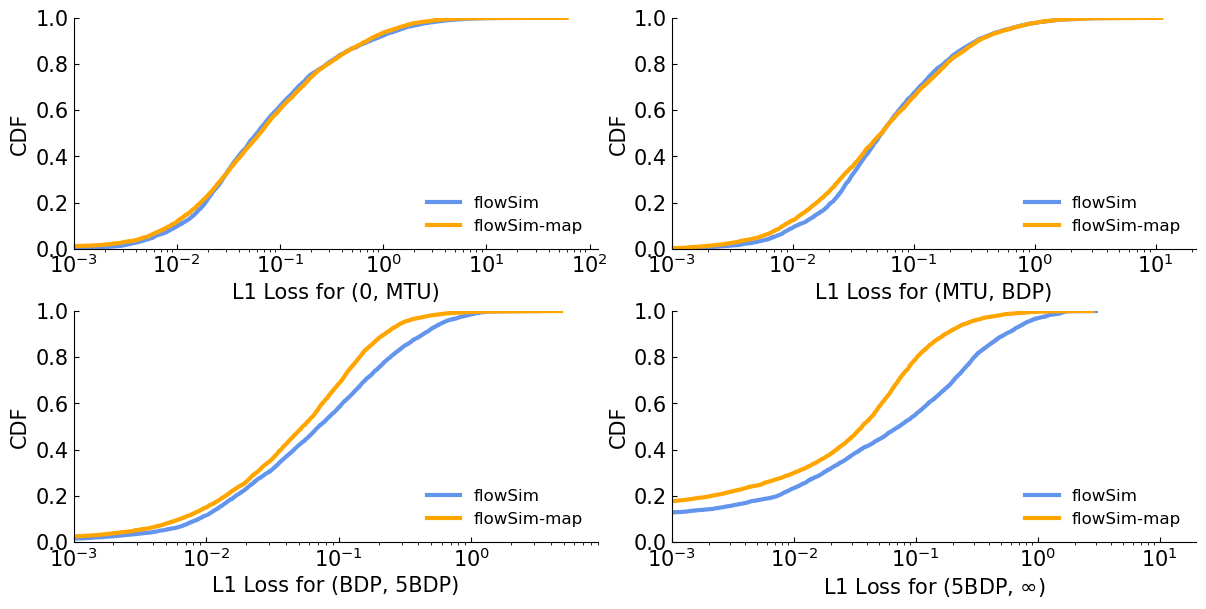

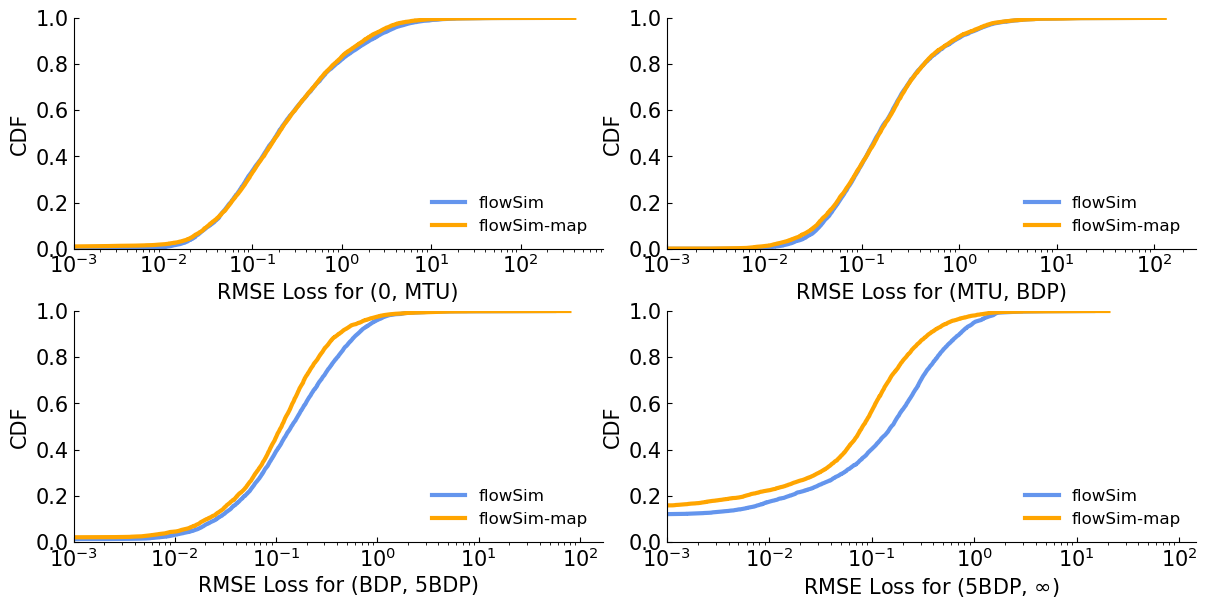

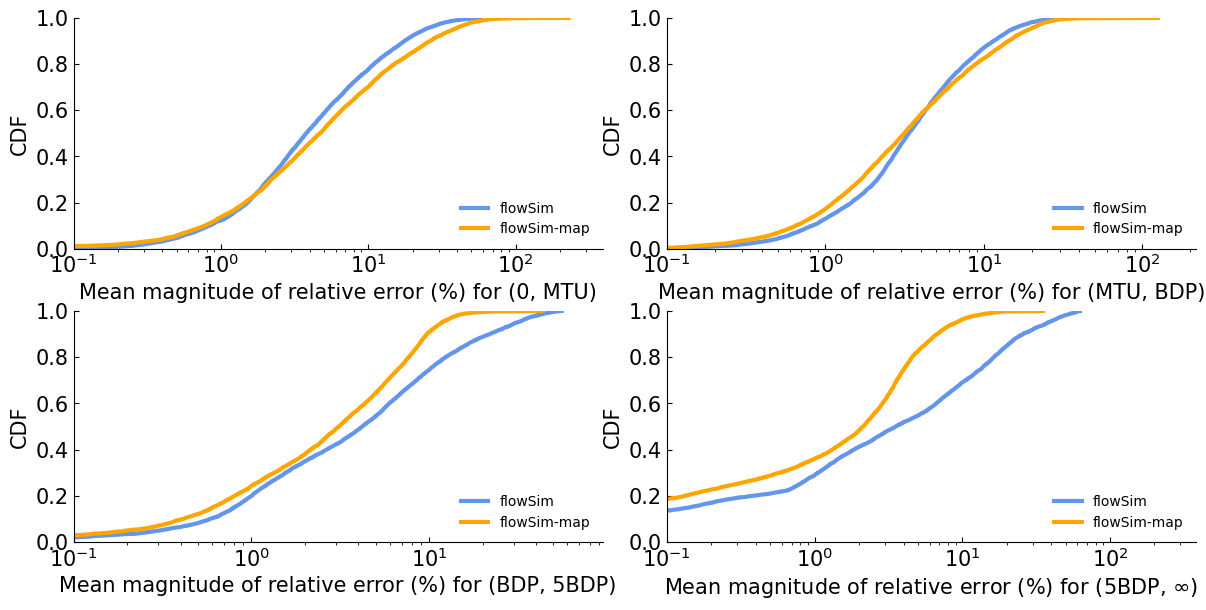

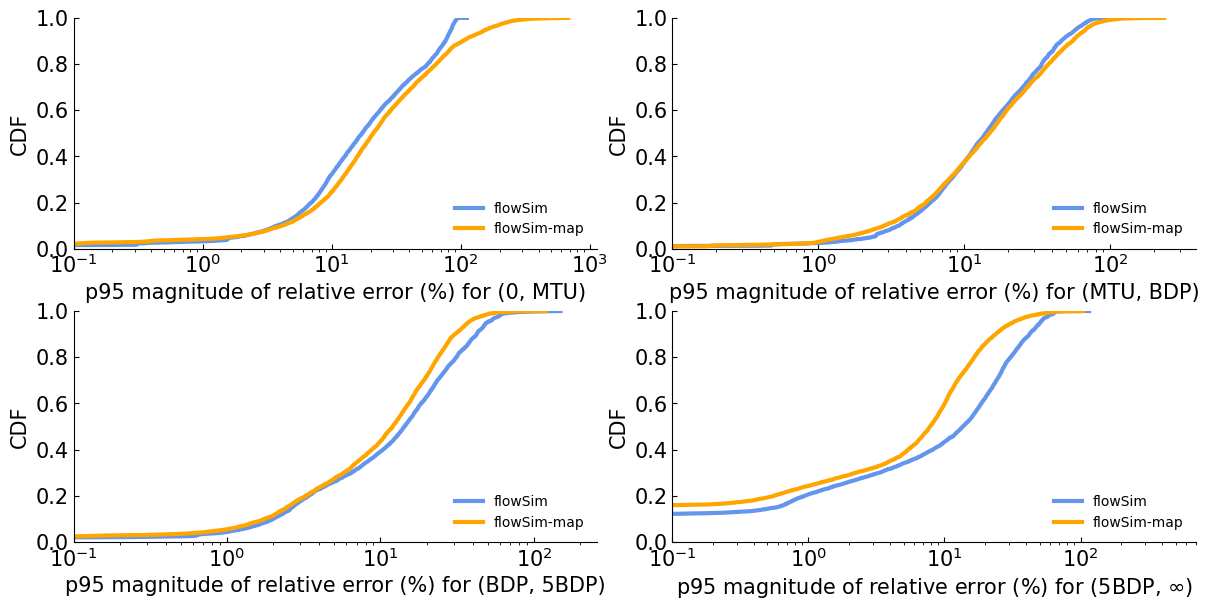

In [15]:

fig_idx=0
# res_error_flattened = []
# for i in range(res_error.shape[1]):
#     res_error_flattened.append(res_error[:,i,:,:,0].flatten())
# legend_list=[f"#hops={nhosts}-L1" for nhosts in nhosts_list]
# for i in range(res_error.shape[1]):
#     res_error_flattened.append(res_error[:,i,:,:,1].flatten())
# legend_list+=[f"#hops={nhosts}-RMSE" for nhosts in nhosts_list]
# plot_cdf(res_error_flattened,None,legend_list,'Loss',legend_font=15,group_size=len(legend_list)//2,loc=2,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx)

# fig_idx+=1
# res_error_flattened = []
# for i in range(res_error.shape[1]):
#     res_error_flattened.append(res_error[:,i,:,:,2].flatten()*100)
# legend_list=[f"#hops={nhosts}" for nhosts in nhosts_list]
# plot_cdf(res_error_flattened,None,legend_list,'Mean magnitude of relative estimation error (%)',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)

method_list=['flowSim','flowSim-map']
plt.figure(fig_idx,figsize=(12, 6))
for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
    res_error_flattened = []
    res_error_flattened.append(res_error[:,:,:,i,0,0].flatten())
    res_error_flattened.append(res_error[:,:,:,i,1,0].flatten())
    plt.subplot(2, 2, i + 1)
    plot_cdf_sub(res_error_flattened,None,method_list,f'L1 Loss for {SIZE_BUCKET_LIST_OUTPUT[i]}',legend_font=12,group_size=len(method_list),loc=4,rotate_xaxis=False,log_switch=True,xlim_bottom=0.001)
fig_idx+=1

plt.figure(fig_idx,figsize=(12, 6))
for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
    res_error_flattened = []
    res_error_flattened.append(res_error[:,:,:,i,0,1].flatten())
    res_error_flattened.append(res_error[:,:,:,i,1,1].flatten())
    plt.subplot(2, 2, i + 1)
    plot_cdf_sub(res_error_flattened,None,method_list,f'RMSE Loss for {SIZE_BUCKET_LIST_OUTPUT[i]}',legend_font=12,group_size=len(method_list),loc=4,rotate_xaxis=False,log_switch=True,xlim_bottom=0.001)
fig_idx+=1

plt.figure(fig_idx,figsize=(12, 6))
for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
    res_error_flattened = []
    res_error_flattened.append(res_error[:,:,:,i,0,2].flatten()*100)
    res_error_flattened.append(res_error[:,:,:,i,1,2].flatten()*100)
    plt.subplot(2, 2, i + 1)
    plot_cdf_sub(res_error_flattened,None,method_list,f'Mean magnitude of relative error (%) for {SIZE_BUCKET_LIST_OUTPUT[i]}',legend_font=10,group_size=len(method_list),loc=4,rotate_xaxis=False,log_switch=True,xlim_bottom=0.1)
fig_idx+=1

plt.figure(fig_idx,figsize=(12, 6))
for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
    res_error_flattened = []
    res_error_flattened.append(res_error[:,:,:,i,0,3].flatten()*100)
    res_error_flattened.append(res_error[:,:,:,i,1,3].flatten()*100)
    plt.subplot(2, 2, i + 1)
    plot_cdf_sub(res_error_flattened,None,method_list,f'p95 magnitude of relative error (%) for {SIZE_BUCKET_LIST_OUTPUT[i]}',legend_font=10,group_size=len(method_list),loc=4,rotate_xaxis=False,log_switch=True,xlim_bottom=0.1)
fig_idx+=1


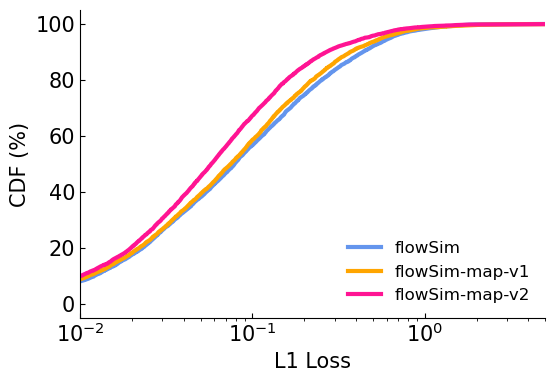

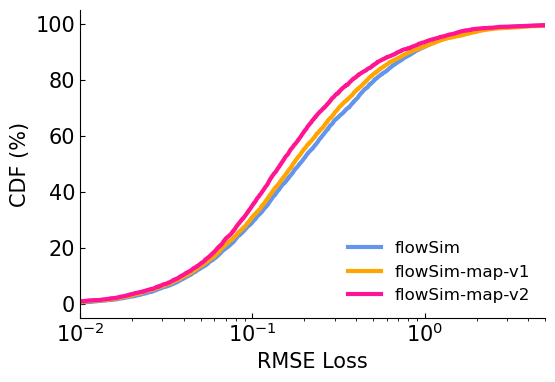

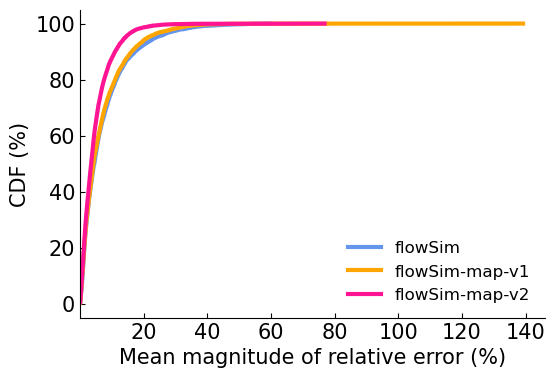

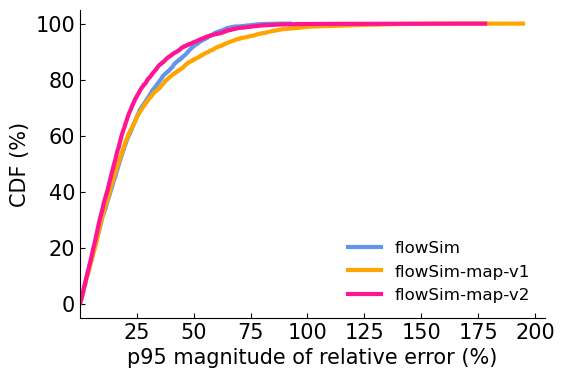

In [19]:
method_list=['flowSim','flowSim-map-v1','flowSim-map-v2']

fig_idx+=1
res_error_flattened = []
target_idx=len(SIZE_BUCKET_LIST_OUTPUT)
for i in range(res_error.shape[4]):
    res_error_flattened.append(res_error[:,:,:,target_idx,i,0].flatten())
res_error_flattened.append(res_error[:,:,:,target_idx+1,-1,0].flatten())
plot_cdf(res_error_flattened,None,method_list,'L1 Loss',legend_font=12,group_size=len(method_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx,xlim_bottom=0.01,xlim=5)

fig_idx+=1
res_error_flattened = []
for i in range(res_error.shape[4]):
    res_error_flattened.append(res_error[:,:,:,target_idx,i,1].flatten())
res_error_flattened.append(res_error[:,:,:,target_idx+1,-1,1].flatten())
plot_cdf(res_error_flattened,None,method_list,'RMSE Loss',legend_font=12,group_size=len(method_list),loc=4,rotate_xaxis=False,log_switch=True,fig_idx=fig_idx,xlim_bottom=0.01,xlim=5)

fig_idx+=1
res_error_flattened = []
for i in range(res_error.shape[4]):
    res_error_flattened.append(res_error[:,:,:,target_idx,i,2].flatten()*100)
res_error_flattened.append(res_error[:,:,:,target_idx+1,-1,2].flatten()*100)
plot_cdf(res_error_flattened,None,method_list,'Mean magnitude of relative error (%)',legend_font=12,group_size=len(method_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx,xlim_bottom=0.1)

fig_idx+=1
res_error_flattened = []
for i in range(res_error.shape[4]):
    res_error_flattened.append(res_error[:,:,:,target_idx,i,3].flatten()*100)
res_error_flattened.append(res_error[:,:,:,target_idx+1,-1,3].flatten()*100)
plot_cdf(res_error_flattened,None,method_list,'p95 magnitude of relative error (%)',legend_font=12,group_size=len(method_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx,xlim_bottom=0.1)

1
spec=shard2_nflows20000_nhosts5_lr10Gbps,_topo-pl-5_s0


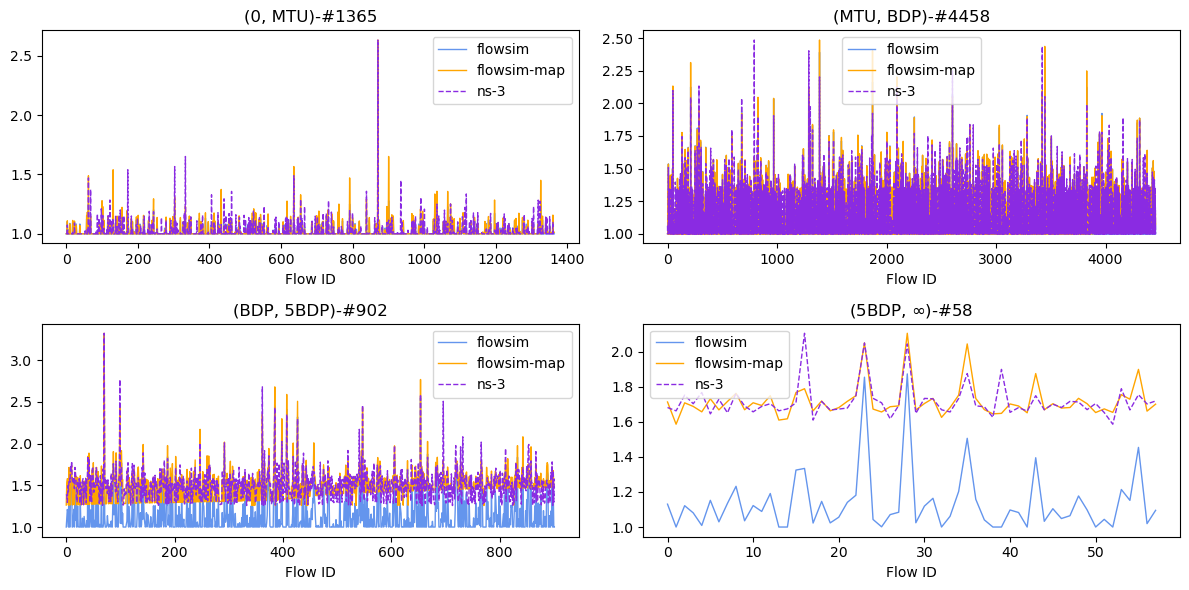

In [83]:

data_list=[]
# for shard in np.arange(10):
for shard in [2]: # 2,8
    for n_flows in [20000]:
        # for n_hosts in [3,5,7]:
        for n_hosts in [5]:
            # for shard_seed in [0,1,2,3]:
            for shard_seed in [0]:
                topo_type=topo_type_ori.replace("-x_",f"-{n_hosts}_")+"s%d"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps{dir_input_str}"
                data_list.append((spec,(0,n_hosts-1),topo_type))
print(len(data_list))
# [FINAL]: ns3 vs flowSim

res_error=[]
fig_index=0
plt.figure(fig_index,figsize=(12, 6))
for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    print(f"spec={spec},{topo_type}")
    dir_input_tmp = f"{dir_input}/{spec}"
    
    tmp = spec.split("_")
    n_hosts=int(tmp[2][6:])
    
    # dctcp_k_str=topo_type[9:]
    # param_vec = np.load(f"{dir_input_tmp}/param{topo_type}.npy")
    # print(f"param_vec={param_vec}")
    
    fid=np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
    sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
    fats_flowsim = np.load(f"{dir_input_tmp}/fat.npy")
    flow_src_dst_flowsim=np.load(f'{dir_input_tmp}/fsd.npy')
    # assert is_sorted(fid)
    
    # flowsim
    flow_idx_target_flowsim=np.logical_and(flow_src_dst_flowsim[:,0]==src_dst_pair_target[0], flow_src_dst_flowsim[:,1]==src_dst_pair_target[1])

    flow_idx_nontarget_flowsim=~flow_idx_target_flowsim
    flow_idx_nontarget_internal_flowsim=np.logical_and(flow_src_dst_flowsim[:,0]!=src_dst_pair_target[0], flow_src_dst_flowsim[:,1]!=src_dst_pair_target[1])

    n_links_passed=abs(flow_src_dst_flowsim[:,0]-flow_src_dst_flowsim[:,1])+flow_idx_nontarget_flowsim+flow_idx_nontarget_internal_flowsim
    
    delay_extra=LINK_TO_DELAY_DICT[n_hosts][flow_src_dst_flowsim[:,0]]+LINK_TO_DELAY_DICT[n_hosts][flow_src_dst_flowsim[:,1]]
    base_delay=get_base_delay(sizes_flowsim,n_links_passed,lr_bottleneck,flow_idx_target_flowsim,flow_idx_nontarget_internal_flowsim)+delay_extra
    i_fcts_flowsim = get_base_delay_transmission(sizes_flowsim,lr_bottleneck) + base_delay
    fcts_flowsim = np.load(f'{dir_input}/{spec}/fct_flowsim.npy')+ base_delay
    sldns_flowsim = np.divide(fcts_flowsim, i_fcts_flowsim)

    sizes_flowsim_target=sizes_flowsim[flow_idx_target_flowsim]
    sldns_flowsim_target=sldns_flowsim[flow_idx_target_flowsim]
    # fcts_flowsim_target=fcts_flowsim[flow_idx_target_flowsim]
    # i_fcts_flowsim_target=i_fcts_flowsim[flow_idx_target_flowsim]
    bins_flowsim_target = np.digitize(sizes_flowsim_target, SIZE_BUCKET_LIST)
    
    # ns-3
    # sizes=sizes_flowsim[fid]
    # fats=fats_flowsim[fid]
    # flow_src_dst=flow_src_dst_flowsim[fid]
    sizes=sizes_flowsim
    fats=fats_flowsim
    flow_src_dst=flow_src_dst_flowsim
    
    flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
    
    fcts = np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    i_fcts = np.load(f'{dir_input_tmp}/fct_i{topo_type}.npy')
    sldns = np.divide(fcts, i_fcts)
    # sldns = i_fcts
    
    
    # flow_idx_target=~flow_idx_target
    sizes_target=sizes[flow_idx_target]
    sldns_target=sldns[flow_idx_target]
    # fcts_target=fcts[flow_idx_target]
    # i_fcts_target=i_fcts[flow_idx_target]
    
    bins_target = np.digitize(sizes_target, SIZE_BUCKET_LIST)
    
    # print(f"sizes={len(sizes)}, fats={len(fats)}, fcts={len(fcts)}, i_fcts={len(i_fcts)}, sldns={len(sldns)}")
    # deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
    # print(f"{deq_time_max}s")
    
    for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
        gt = np.extract(bins_target==i, sldns_target)
        gt_flowsim = np.extract(bins_flowsim_target==i, sldns_flowsim_target)
        
        plt.subplot(2, 2, i + 1)
        plt.title(f"{SIZE_BUCKET_LIST_OUTPUT[i]}-#{len(gt)}")
        if(len(gt)==0): continue
        
        plot_ns3=gt
        plot_flowsim=map_percentiles(gt_flowsim,gt)
        
        res_error.append(np.abs(plot_ns3-plot_flowsim)/plot_ns3*100)
        plt.plot(gt_flowsim, label="flowsim", linewidth=1,color=color_list[0])
        plt.plot(plot_flowsim, label="flowsim-map", linewidth=1,color=color_list[1])
        
        plt.plot(plot_ns3, label="ns-3", linewidth=1,color=color_list[3],linestyle='dashed')

        # plt.axhline(99, color='green', linewidth=0.5)
        # plt.xscale('log')
        plt.xlabel('Flow ID')
        plt.legend()
        # plt.xlim([0, 16])
        # plt.ylim([80, 100])
    plt.tight_layout()
fig_index+=1


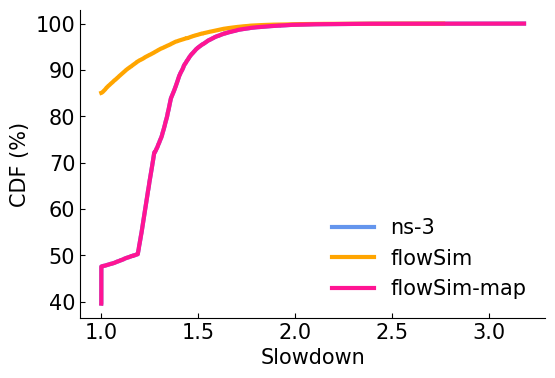

In [74]:
plot_cdf([sldns_target,sldns_flowsim_target,map_percentiles(sldns_flowsim_target,sldns_target)],None,['ns-3',"flowSim","flowSim-map"],'Slowdown',legend_font=15,group_size=3,loc=4,rotate_xaxis=False,log_switch=False)

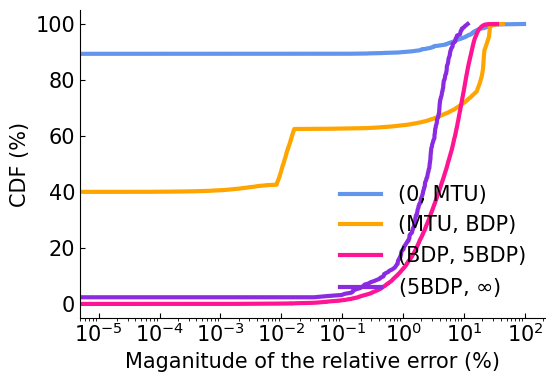

In [75]:

plot_cdf(res_error,None,SIZE_BUCKET_LIST_OUTPUT,'Maganitude of the relative error (%)',legend_font=15,group_size=len(SIZE_BUCKET_LIST_OUTPUT),loc=4,rotate_xaxis=False,log_switch=True)

1
spec=shard3_nflows20000_nhosts7_lr10Gbps,_topo-pl-7_s0
param_vec=[  0.     29.      9.673   1.      0.      0.      0.      1.      0.
   0.      0.      0.      0.     53.314 128.348]
sizes=120000, fats=120000, fcts=120000, i_fcts=120000, sldns=120000
33.239s
************************************************************************************************************************************************
shard3_nflows20000_nhosts7_lr10Gbps
p99 percentile: 1.1663751729035943
p99 percentile: 1.5613135298840932
p99 percentile: 2.0999747546706637
p99 percentile: 2.3319339893119624


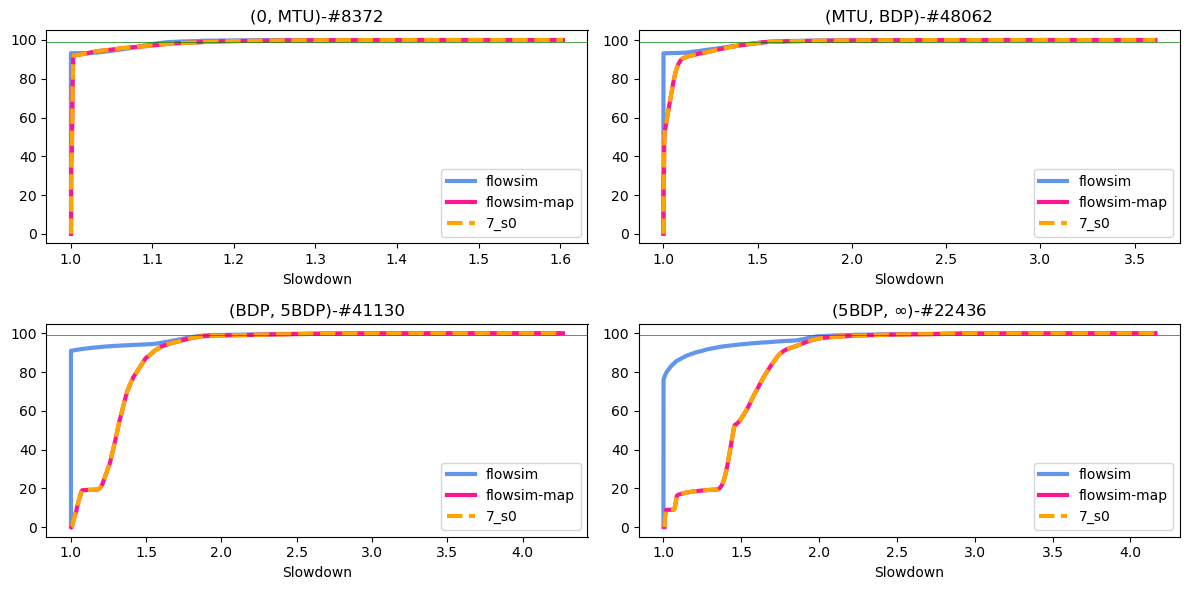

In [23]:
data_list=[]
# for shard in np.arange(10):
for shard in [3]:
    for n_flows in [20000]:
        # for n_hosts in [3,5,7]:
        for n_hosts in [7]:
            # for shard_seed in [0,1,2,3]:
            for shard_seed in [0]:
                topo_type=topo_type_ori.replace("-x_",f"-{n_hosts}_")+"s%d"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps{dir_input_str}"
                dir_input_tmp = f"{dir_input}/{spec}"
                stats=decode_dict(np.load(f'{dir_input_tmp}/stats.npy', allow_pickle=True,encoding="bytes").item())
                n_flows_total=stats["n_flows"]
                if enable_longest_foreground_traffic:
                    data_list.append((spec,(0,n_hosts-1),topo_type))
print(len(data_list))
# [FINAL]: ns3 vs flowSim
lr_bottleneck=lr
fig_index=0
plt.figure(fig_index,figsize=(12, 6))
for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    print(f"spec={spec},{topo_type}")
    dir_input_tmp = f"{dir_input}/{spec}"
    
    tmp = spec.split("_")
    n_hosts=int(tmp[2][6:])
    
    dctcp_k_str=topo_type[9:]
    
    param_vec = np.load(f"{dir_input_tmp}/param{topo_type}.npy")
    print(f"param_vec={param_vec}")
    
    fid=np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
    sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
    fats_flowsim = np.load(f"{dir_input_tmp}/fat.npy")
    flow_src_dst_flowsim=np.load(f'{dir_input_tmp}/fsd.npy')
    
    if (spec_idx==0):
        # flowsim
        flow_idx_target_flowsim=np.logical_and(flow_src_dst_flowsim[:,0]==src_dst_pair_target[0], flow_src_dst_flowsim[:,1]==src_dst_pair_target[1])

        flow_idx_nontarget_flowsim=~flow_idx_target_flowsim
        flow_idx_nontarget_internal_flowsim=np.logical_and(flow_src_dst_flowsim[:,0]!=src_dst_pair_target[0], flow_src_dst_flowsim[:,1]!=src_dst_pair_target[1])

        n_links_passed=abs(flow_src_dst_flowsim[:,0]-flow_src_dst_flowsim[:,1])+flow_idx_nontarget_flowsim+flow_idx_nontarget_internal_flowsim
        
        delay_extra=LINK_TO_DELAY_DICT[n_hosts][flow_src_dst_flowsim[:,0]]+LINK_TO_DELAY_DICT[n_hosts][flow_src_dst_flowsim[:,1]]
        base_delay=get_base_delay(sizes_flowsim,n_links_passed,lr_bottleneck,flow_idx_target_flowsim,flow_idx_nontarget_internal_flowsim)+delay_extra
        i_fcts_flowsim = get_base_delay_transmission(sizes_flowsim,lr_bottleneck) + base_delay
        fcts_flowsim = np.load(f'{dir_input}/{spec}/fct_flowsim.npy')+ base_delay
        sldns_flowsim = np.divide(fcts_flowsim, i_fcts_flowsim)

        sizes_flowsim_target=sizes_flowsim[flow_idx_target_flowsim]
        sldns_flowsim_target=sldns_flowsim[flow_idx_target_flowsim]
        fcts_flowsim_target=fcts_flowsim[flow_idx_target_flowsim]
        i_fcts_flowsim_target=i_fcts_flowsim[flow_idx_target_flowsim]
        bins_flowsim = np.digitize(sizes_flowsim, SIZE_BUCKET_LIST)
    
    # ns-3
    sizes=sizes_flowsim[fid]
    fats=fats_flowsim[fid]
    flow_src_dst=flow_src_dst_flowsim[fid]
    
    flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
    
    fcts = np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    i_fcts = np.load(f'{dir_input_tmp}/fct_i{topo_type}.npy')
    sldns = np.divide(fcts, i_fcts)
    # sldns = i_fcts
    
    
    # flow_idx_target=~flow_idx_target
    sizes_target=sizes[flow_idx_target]
    sldns_target=sldns[flow_idx_target]
    fcts_target=fcts[flow_idx_target]
    i_fcts_target=i_fcts[flow_idx_target]
    
    bins = np.digitize(sizes, SIZE_BUCKET_LIST)
    
    print(f"sizes={len(sizes)}, fats={len(fats)}, fcts={len(fcts)}, i_fcts={len(i_fcts)}, sldns={len(sldns)}")
    deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
    print(f"{deq_time_max}s")
    
    print("************************************************************************************************************************************************")
    print(f'{spec}')
    for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
        gt = np.extract(bins==i, sldns)
        gt_flowsim = np.extract(bins_flowsim==i, sldns_flowsim)
        gt_flowsim_map=map_percentiles(gt_flowsim,gt)
        print(f"p99 percentile: {np.percentile(gt,99)}")
        
        plt.subplot(2, 2, i + 1)
        plt.title(f"{SIZE_BUCKET_LIST_OUTPUT[i]}-#{len(gt)}")
        if(len(gt)==0): continue
        # plt.xlim([0, 16])
        
        if (spec_idx==0):
            plt.plot(np.sort(gt_flowsim), (np.arange(len(gt_flowsim))/len(gt_flowsim)*100), label="flowsim", linewidth=3,color=color_list[spec_idx])
            
            plt.plot(np.sort(gt_flowsim_map), (np.arange(len(gt_flowsim_map))/len(gt_flowsim_map)*100), label="flowsim-map", linewidth=3,color=color_list[spec_idx+2])
            
        plt.plot(np.sort(gt), (np.arange(len(gt))/len(gt)*100), label=dctcp_k_str, linewidth=3,color=color_list[spec_idx+1],linestyle='dashed')

        plt.axhline(99, color='green', linewidth=0.5)
        # plt.xscale('log')
        plt.xlabel('Slowdown')
        plt.legend()
        # plt.ylim([80, 100])
    plt.tight_layout()
fig_index+=1

# plot_cdf(res,None,legend_list,'P99 slowdown',legend_font=15,group_size=len(res),loc=4,rotate_xaxis=False)